This script estimates the performance of naive bayes classification in a document-topic model's feature space

In [1]:
%load_ext autoreload
%autoreload 2
import time
start_time = time.time()

import json

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import numpy as np

import sys
sys.path.append("../libraries/")
from selector import split_data
from semanticClassifiers import docTopTransformer2, doc2Bow

In [2]:
# takes list of text fields (e.g. summary or reviewText fields) and
# tokenizes, removes stop words and stems. Returns result as array of 
# lists, one list per review
def preprocess_data(doc_set):    
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        if not i:
            i = ' '
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        tokens.append('null__') # add a bias term, will work as a kind of prior, important for empty reviews
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts

# takes an array of lists as input, product labels, uniq_labels, and ratings,
# and merges lists with matching labels among labels uniq_labels, averages
# reviews belonging to the same, returns merged lists, and averaged ratings
# uniq_labels should typically be np.unique(product labels), however 
# the option of specifying a subset is useful for parallelization to allow
# different subsets to be processed by different engines
def combine_reviews(text, asins, ratings):
        products = [asins[0]]
        combined_text = [text[0]]
        average_rating = []
        total_rating = ratings[0]
        count = 1

        #combine all the summaries into a single text and avg the review ratings for each product
        for i in range(1, len(asins)):
            last_element_index = len(products) - 1
            if(asins[i] == products[last_element_index]):
                combined_text[last_element_index] = combined_text[last_element_index] + text[i]
                total_rating += ratings[i]
                count += 1
            else:
                average_rating.append(total_rating/count)
                products.append(asins[i])
                combined_text.append(text[i])
                total_rating = ratings[i]
                count = 1
        average_rating.append(total_rating/count)
        
        return (combined_text, products, average_rating)

In [22]:
# Read in testing data for 80/20 split
# we won't use val_dat at all
t1 = time.time()
json_dat, val_dat = split_data('../data/Sports_and_Outdoors_Reviews_training.json', 80)
t2 = time.time()
t2 - t1

351.8517847061157

In [41]:
# Only sample of data
samples = json_dat[:10000]
#sort test data by asin
samples = sorted(samples, key=lambda k: k['asin'])

In [42]:
# create a list, doc_list, with one review per elem
review = []
summary = []
rating = []
prod_id = []
for i in range(0,len(samples)):
    rating.append(samples[i].get('overall'))
    summary.append(samples[i].get('summary'))
    review.append(samples[i].get('reviewText'))
    prod_id.append(samples[i].get('asin'))

In [43]:
len(review), len(summary), len(rating), len(prod_id)

(10000, 10000, 10000, 10000)

In [44]:
# takes ~96 CPU minutes

# this cell runs things in parallel. make sure to start an 
# ipython cluster from the notebook dashboard's IPython Cluster
# tab before running
import ipyparallel as ipp

rc = ipp.Client()
dview = rc[:]
dview.execute('from nltk.tokenize import RegexpTokenizer;' +
              'from nltk.corpus import stopwords; ' + 
              'from nltk.stem.porter import PorterStemmer;' +
              'import numpy as np;')

t0 = time.time()


# clean text
dview.push(dict(preprocess_data=preprocess_data))
dview.scatter('summary', summary) # partitions data

%px cleaned_reviews = preprocess_data(summary)
cleaned_reviews = dview.gather('cleaned_reviews').get()

# combine text
total_text, uniq_prod_id, avg_ratings = combine_reviews(cleaned_reviews, prod_id, rating)


t1 = time.time()

print(t1-t0)

1.0140130519866943


In [174]:
#parallel_avg_ratings = avg_ratings
#parallel_total_text = total_text

In [45]:
# uncomment this box to run serially

cleaned_reviews = preprocess_data(summary)
uniq_prod_id = np.unique(prod_id)
total_text, avg_ratings = combine_reviews(cleaned_reviews, prod_id, uniq_prod_id, rating)

TypeError: combine_reviews() takes 3 positional arguments but 4 were given

In [ ]:
#print(parallel_avg_ratings == avg_ratings)
#all([all(parallel_total_text[i] == text) for i, text in enumerate(total_text)])

In [14]:
import gc

del summary
del review
del json_dat
del val_dat

gc.collect()

274184

In [46]:
# vectorize training data
train_lbls = np.array(avg_ratings) >= 4.5
train_text = total_text

In [47]:
len(train_text), len(train_lbls)

(346, 346)

In [53]:
# estimate classifier accuracy
from sklearn.model_selection import cross_val_predict, KFold, GridSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer, FunctionTransformer

# GroupKFold gives you a KFold partitioner that abides by
# product labels so that products are only ever in a single
# fold
kf = KFold(n_splits=10)
cv = kf.split(train_text, train_lbls)

time0 = time.time()

# initialize a transformer mapping from bow to latent semantic features
doc2Top = docTopTransformer2()

# initialize a normalization transformer
norm_transformer = Normalizer()

# pick a classifier
baseClf = SVC()

params = [{'kernel': ['rbf'], 'C': [1, 10, 100, 1000]},
            {'kernel': ['poly'], 'degree': [2,3,4]}]

#estimators = [('projection', doc2Top), ('baseClf', baseClf)]
#semClf = Pipeline(estimators)

grid_LSVC = GridSearchCV(estimator = baseClf, param_grid = params, scoring = 'f1_macro', 
                       cv = 10, verbose = 1, n_jobs = 1)

n_estimators=10
clf = BaggingClassifier(base_estimator=grid_LSVC, 
                        bootstrap=False, max_samples = 1.0/n_estimators, n_estimators=n_estimators,
                        n_jobs=1)

# create a pipeline that transforms data to semantic space, 
# and then classifies them by averaging over n_estimators of 
# type baseClf
#
# Note, you could bag over n semantic models too by creating
# a pipeline using bow2Top and baseClf, and then passing that
# in as th base_estimator argument of a BaggingClassifier
# instance. If you think bagging classification of reviews will
# lead to better classification performance for theoretical
# reasons, this would be the way to go, however the purpose
# of bagging here is for to avoid a bypass the slow SVM fitting
# procedure
estimators = [('projection', doc2Top), ('normalization', norm_transformer), ('clf', clf)]
semBagClf = Pipeline(estimators)

# cross validate over the pipeline using group k-fold CV
print(len(train_lbls), len(train_text))
pred_lbls = cross_val_predict(semBagClf, train_text, train_lbls, cv=cv, n_jobs=4)
time1 = time.time()

print(time1-time0)

346 346
23.507967233657837


In [54]:
from sklearn.metrics import classification_report

report = classification_report(train_lbls, pred_lbls)
print('True recall is sensitivity, false recall is specificity')
print(report)

# this is not exactly the same as the average of each CV folds accuracy, 
# but it's close and much faster to compute
acc = 1-np.mean(pred_lbls != train_lbls)
print("Accuracy: %0.3f" % acc)

True recall is sensitivity, false recall is specificity
              precision    recall  f1-score   support

       False       0.60      0.78      0.68       174
        True       0.69      0.48      0.57       172

    accuracy                           0.63       346
   macro avg       0.65      0.63      0.62       346
weighted avg       0.64      0.63      0.62       346

Accuracy: 0.633


In [50]:
#clf.n_jobs = 5
clf = BaggingClassifier(base_estimator=grid_LSVC, 
                        bootstrap=False, max_samples = 1.0/n_estimators, n_estimators=n_estimators,
                        n_jobs=5)

estimators = [('projection', doc2Top), ('normalization', norm_transformer), ('clf', clf)]
semBagClf = Pipeline(estimators)

semBagClf = semBagClf.fit(train_text,train_lbls)

In [ ]:
# save fitted classifier
#
# classifier will project tokenized test data to the pretrained 
# document-topic embedding, apply two SVM classifiers, which may
# be linear, polynomial or RBF kernel classifiers, with various
# hyperparameters, average the results, and give you the 
# resulting prediction. The selected kernels and hyperparameters
# are chosen to optimize f1 score
#import pickle
#with open('linearSVM.clf',mode='wb') as f:
#    pickle.dump(semClf,f)

(array([  2.,   0.,   2.,   2.,  13.,  11.,  39.,  77., 111.,  89.]),
 array([2. , 2.3, 2.6, 2.9, 3.2, 3.5, 3.8, 4.1, 4.4, 4.7, 5. ]),
 <BarContainer object of 10 artists>)

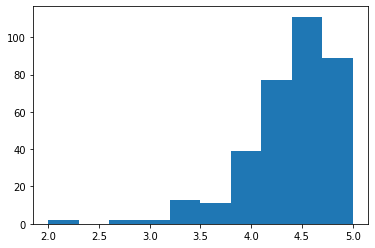

In [51]:
from matplotlib import pyplot as plt
plt.hist(avg_ratings)